In [3]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")
#sys.path.append("/home2/datahome/tpicard/PhD_MOMOPAR/TRAIN_AND_VALIDATION_CNN/OLD/")
import torch
from torch.utils.data import DataLoader, Dataset
from CNN_tools import *
from pytorch_lightning.callbacks import ModelCheckpoint
from variables import *
import importlib

# MAIN MODEL
SMOOTH = 1e-8

def iou_numpy(outputs, labels):
    #outputs = outputs.squeeze(1)

    outputs = np.where(outputs>0.0002,1,0)
    labels = np.where(labels>0.0002,1,0)
    intersection = (outputs & labels).sum((0, 1))
    union = (outputs | labels).sum((0, 1))
    
    #iou = 1 - (intersection + SMOOTH) / (union + SMOOTH)
    iou = 1 - ((intersection + SMOOTH) / (outputs.sum((0, 1)) + SMOOTH))

    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return iou  # Or thresholded.mean()

def iou_particles(outputs, labels):
    #outputs = outputs.squeeze(1)

    outputs_bin = np.where(outputs>0.0002,1,0)
    labels = np.where(labels>0.0002,1,0)
    intersection = np.multiply(outputs_bin,labels)
    outputs_bin = np.where(intersection==1,outputs,0)
    iou = 1- np.sum(outputs_bin)

    return iou  # Or thresholded.mean()

def distribution_valid(title,list_metric,name_x):

    fig = plt.figure(figsize=(10,6))
    bin = np.linspace(0,1,21)
    hist,edge = np.histogram(list_metric, bins=bin)
    plt.hist(list_metric, bins=bin, density=False,histtype='stepfilled',alpha=0.8)
    plt.grid()
    plt.ylabel('Nb cases',size = 16)
    plt.xlabel(name_x,size = 16)
    coef = list_metric.shape[0]/100

    BC01 = np.sum(np.where(list_metric <0.2,1,0))/coef
    BC02 = np.sum(np.where(list_metric >0.3,1,0))/coef
    BC03 = (list_metric.shape[0] - BC01*coef - BC02*coef)/coef

    props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='k')
    textstr1 = str(round(BC01))+'%'
    textstr2 = str(round(BC02))+'%'
    textstr3 = str(round(BC03))+'%'
    textstr4 = ' Mean metric :' + str(np.round(np.mean(list_metric),2))
    # place a text box in upper left in axes coords
    textstr = 'BC < 0.2 = '+str(round(BC01))+'%'+'\n'+'0.2 < BC < 0.3 = '+str(round(BC03))+'%'+'\n'+'BC > 0.3 = '+str(round((BC02)))+'%'
    # place a text box in upper left in axes coords
    plt.text(0.05, 400, textstr1, fontsize=14,
            verticalalignment='top', bbox=props,color ='green')
    plt.text(0.22, 400, textstr3, fontsize=14,
            verticalalignment='top', bbox=props,color='orange')
    plt.text(0.5, 400, textstr2, fontsize=14,
            verticalalignment='top', bbox=props,color='red')
    plt.text(0.5, 600, textstr4, fontsize=14,
            verticalalignment='top', bbox=props,color='red')

    plt.vlines(0.2,0,2000,colors='k',linestyle='--')
    plt.vlines(0.3,0,2000,colors='k',linestyle='--')
    plt.ylim(0,np.max(hist)+20)
    plt.xlim(0,0.8)
    plt.title(title,size=20)
    

# Load network predictions

In [6]:

folder = "../DATA/"

nc = nc4.Dataset(folder+'unet_surf_nb.nc','r')
model_surf = np.asfortranarray(nc.variables['super_model_norm'])
nc.close()

nc = nc4.Dataset(folder+'basic_cnn_surf.nc','r')
model_surf_1stair = np.asfortranarray(nc.variables['super_model_norm'])
nc.close()

nc = nc4.Dataset(folder+'supermodel_4L.nc','r')
super_model_4L = np.asfortranarray(nc.variables['super_model_norm'])
nc.close()

nc = nc4.Dataset(folder+'supermodel_surf.nc','r')
super_model_surf = np.asfortranarray(nc.variables['super_model_norm'])
nc.close()


pdf_filter_test = load_pdf_filter_simu2()
pdf_filter_test = np.transpose(pdf_filter_test,(0,2,1,3,4))
pdf_filter_test = pdf_filter_test.reshape(pdf_filter_test.shape[0]*pdf_filter_test.shape[1],8,100,100)
pdf_filter_test = pdf_filter_test[:-36]

baseline = np.mean(pdf_filter_test[:,-1,:,:],axis=0)


Loading filtered pdf simu2 ...
Pdf filtered simu2 loaded


# Score for each networks

In [7]:
list_bhatta_surf = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_surf[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_surf[i,:,:], pdf_filter_test[i,-1,:,:])))))

list_bhatta_4L = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_4L[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_4L[i,:,:], pdf_filter_test[i,-1,:,:])))))

list_bhatta_baseline = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_baseline[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(baseline, pdf_filter_test[i,-1,:,:])))))
    
list_bhatta_model_surf = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_model_surf[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(model_surf[i,:,:], pdf_filter_test[i,-1,:,:])))))

list_bhatta_model_surf_1stair = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_model_surf_1stair[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(model_surf_1stair[i,:,:], pdf_filter_test[i,-1,:,:])))))

# Other metric

'''

list_iou_surf = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_iou_surf[i] = iou_numpy(super_model_surf[i,:,:], pdf_filter_test[i,-1,:,:])

list_iou_4L = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_iou_4L[i] = iou_numpy(super_model_4L[i,:,:], pdf_filter_test[i,-1,:,:])

list_iou_baseline = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_iou_baseline[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(baseline, pdf_filter_test[i,-1,:,:])))))
    
list_iou_model_surf = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_iou_model_surf[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(model_surf[i,:,:], pdf_filter_test[i,-1,:,:])))))

list_iou_model_surf_1stair = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_iou_model_surf_1stair[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(model_surf_1stair[i,:,:], pdf_filter_test[i,-1,:,:])))))
''' 

# PLOT SCORES

"\ndistribution_valid('4L '+str(list_iou_4L.shape[0]) + ' test ',list_iou_4L,'IOU')\ndistribution_valid('Surf ' +str(list_iou_surf.shape[0])+ ' test ',list_iou_surf,'IOU')\ndistribution_valid('Baseline '+str(list_iou_baseline.shape[0]) + ' test ',list_iou_baseline,'IOU')\ndistribution_valid('1 Model surf ' +str(list_iou_model_surf.shape[0])+ ' test ',list_iou_model_surf,'IOU')\ndistribution_valid('Model surf 1 stair' +str(list_iou_model_surf_1stair.shape[0])+ ' test ',list_iou_model_surf_1stair,'BL')\n"

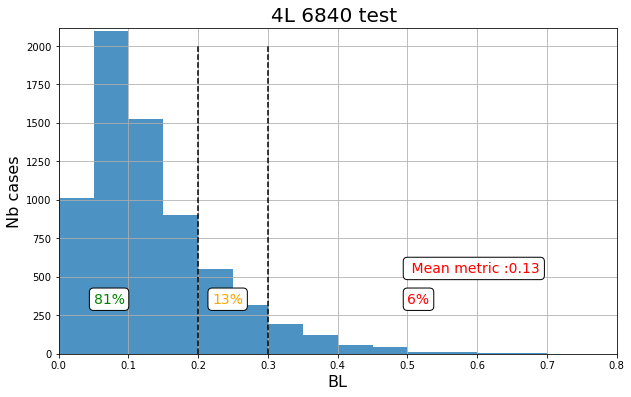

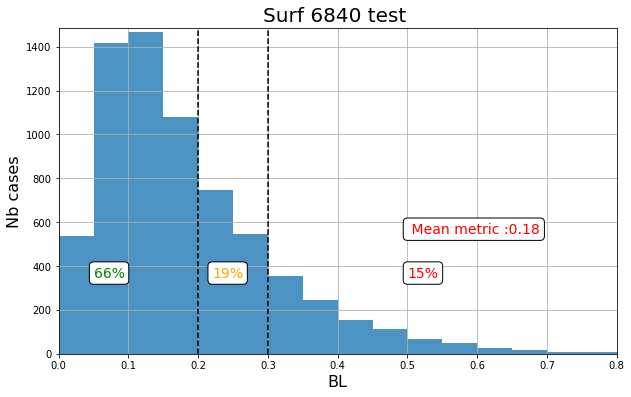

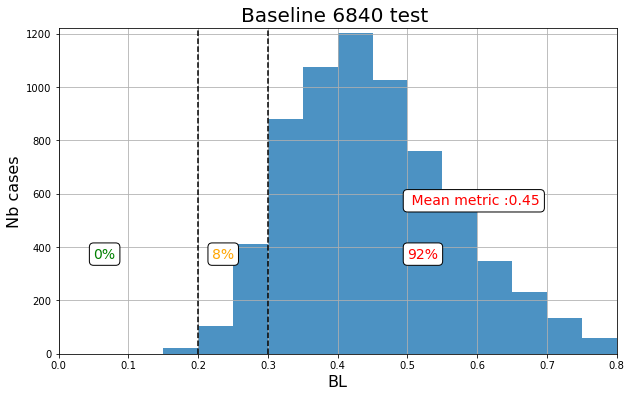

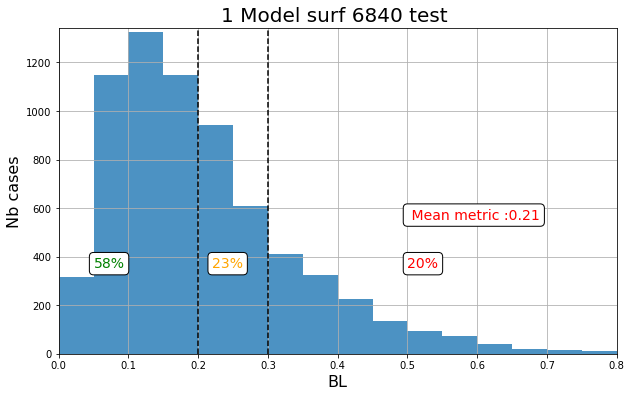

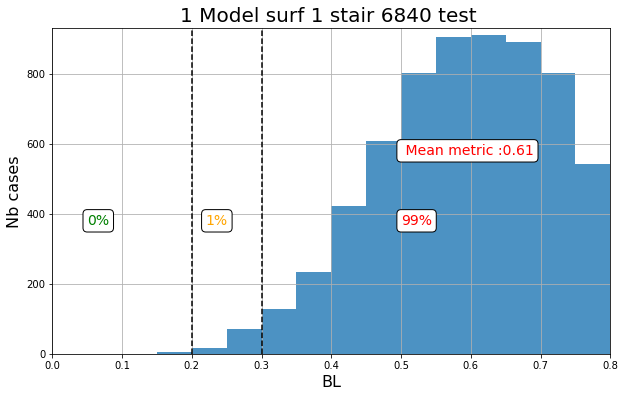

In [17]:
distribution_valid('4L '+str(list_bhatta_4L.shape[0]) + ' test ',list_bhatta_4L,'BL')
distribution_valid('Surf ' +str(list_bhatta_4L.shape[0])+ ' test ',list_bhatta_surf,'BL')
distribution_valid('Baseline '+str(list_bhatta_baseline.shape[0]) + ' test ',list_bhatta_baseline,'BL')
distribution_valid('1 Model surf ' +str(list_bhatta_model_surf.shape[0])+ ' test ',list_bhatta_model_surf,'BL')
distribution_valid('1 Model surf 1 stair ' +str(list_bhatta_model_surf_1stair.shape[0])+ ' test ',list_bhatta_model_surf_1stair,'BL')


'''
distribution_valid('4L '+str(list_iou_4L.shape[0]) + ' test ',list_iou_4L,'IOU')
distribution_valid('Surf ' +str(list_iou_surf.shape[0])+ ' test ',list_iou_surf,'IOU')
distribution_valid('Baseline '+str(list_iou_baseline.shape[0]) + ' test ',list_iou_baseline,'IOU')
distribution_valid('1 Model surf ' +str(list_iou_model_surf.shape[0])+ ' test ',list_iou_model_surf,'IOU')
distribution_valid('Model surf 1 stair' +str(list_iou_model_surf_1stair.shape[0])+ ' test ',list_iou_model_surf_1stair,'BL')
'''